# Clustering

September 2020

Clustering is an unsupervised machine learning technique that is often used to find similarities in data. In the treatment below, the technique is used to segment data according to common patterns (ie mathematically, the data's Euclidean equidistance from an estimated cluster centroid) 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
%matplotlib inline

In [2]:
from mpl_toolkits.mplot3d import Axes3D

### Functions to help plot ideal cluster "elbow" for KMeans

In [3]:
def format_spines(ax, right_border=True):
    """
        this function sets up formats borders of dataviz and personalizes colors
        input:
            ax: figure axis
            right_border: flag to determine if the right border will be visible
    """

    # Setting up colors
    ax.spines['bottom'].set_color('#CCCCCC')
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['top'].set_color('#FFFFFF')
    if right_border:
        ax.spines['right'].set_color('#CCCCCC')
    else:
        ax.spines['right'].set_color('#FFFFFF')
    ax.patch.set_facecolor('#FFFFFF')

def compute_square_distances(df, Kmin=1, Kmax=12):
    """
    this function computes the square distance of the KMeans algorithm through the number of clusters between Kmin and Kmax
    input:
        df: dataframe
        Kmin: min index of K analysis
        Kmax: max index of K analysis
    """

    square_dist = []
    K = range(Kmin, Kmax)
    for k in K:
        km = KMeans(n_clusters=k)
        km.fit(df)
        square_dist.append(km.inertia_)
    return K, square_dist

def plot_elbow_method(df, Kmin=1, Kmax=12):
    """
    this function computes the square distances and plots the elbow method for best cluster number analysis
    input:
        df: dataframe
        Kmin: min index of K analysis
        Kmax: max index of K analysis"""

    # Computing distances
    K, square_dist = compute_square_distances(df, Kmin, Kmax)

    # Plotting elbow method
    fig, ax = plt.subplots()
    ax.plot(K, square_dist, 'bo-')
    format_spines(ax, right_border=False)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Sum of Square Dist')
    plt.title(f'Elbow Method - {df.columns[0]} and {df.columns[1]}', size=14)
    plt.show()



### Load, examine and plot data

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/ginobaltazar7/66daysofdata/master/Clustering/data/Mall_Customers.csv')

In [6]:
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [7]:
df.isnull().sum() # examine for missing values in each column

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [8]:
# rename columns
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('$','').str.replace('-','')
# and drop customerID
df= df.drop(['customerid'], axis=1)
# and rename genre column name
df= df.rename(columns={'genre': 'gender'})

<ipython-input-8-f70947df45ed>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('$','').str.replace('-','')


In [9]:
df.columns

Index(['gender', 'age', 'annual_income_k', 'spending_score_1100'], dtype='object')

In [10]:
#df['male'] = (df['genre'] == 'Male').astype(int)
df['gender'].replace(['Female','Male'], [0,1], inplace=True)

In [11]:
df.head()

,gender,age,annual_income_k,spending_score_1100
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40


### Standardize data

Standardization is an important step of Data preprocessing because it controls the variability of the dataset and converts data into specific range using a linear transformation which generate good quality clusters and improve the accuracy of clustering algorithms.

https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering
https://pdfs.semanticscholar.org/1d35/2dd5f030589ecfe8910ab1cc0dd320bf600d.pdf

In [12]:
dfstd = pd.concat([df.mean().to_frame(), df.std().to_frame()], axis=1).transpose()

In [13]:
dfstd

,gender,age,annual_income_k,spending_score_1100
0,0.440000,38.850000,60.560000,50.200000
0,0.497633,13.969007,26.264721,25.823522


In [15]:
dfstd.index = ['mean', 'std']

In [16]:
dfstd

,gender,age,annual_income_k,spending_score_1100
mean,0.440000,38.850000,60.560000,50.200000
std,0.497633,13.969007,26.264721,25.823522


In [17]:
df_scaled = pd.DataFrame()
for col in df.columns:
    if(col =='gender'):
        df_scaled[col] = df[col]
    else: 
        df_scaled[col+'_s'] = (df[col] - dfstd.loc['mean', col]) / dfstd.loc['std', col]
df_scaled.head()

,gender,age_s,annual_income_k_s,spending_score_1100_s
0,1,-1.421003,-1.734646,-0.433713
1,1,-1.277829,-1.734646,1.192711
2,0,-1.349416,-1.696572,-1.711618
3,0,-1.134655,-1.696572,1.037814
4,0,-0.561958,-1.658498,-0.394989


### Break up dataframe into two

One for male and another female, in part to help reduce data dimensions.


In [18]:
df_female = df_scaled.loc[df_scaled.gender==0].iloc[:, 1:]
df_male = df_scaled.loc[df_scaled.gender==1].iloc[:, 1:]

In [ ]:
df_female.head()

,age_s,annual_income_k_s,spending_score_1100_s
2,-1.349416,-1.696572,-1.711618
3,-1.134655,-1.696572,1.037814
4,-0.561958,-1.658498,-0.394989
5,-1.206242,-1.658498,0.999089
6,-0.275610,-1.620425,-1.711618


In [19]:
df_male.head()

,age_s,annual_income_k_s,spending_score_1100_s
0,-1.421003,-1.734646,-0.433713
1,-1.277829,-1.734646,1.192711
8,1.800414,-1.582351,-1.827791
10,2.015175,-1.582351,-1.401823
14,-0.132436,-1.544277,-1.440547


### Visual spotcheck 

To intuitively help see the distribution of data and patterns visually. Quickly spotchecking, data seems to suggest spending score by age skews slightly younger in both male and female, while skewing slightly towards lower income.

In [20]:
df_male.columns

Index(['age_s', 'annual_income_k_s', 'spending_score_1100_s'], dtype='object')

In [21]:
df_male.shape

(88, 3)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

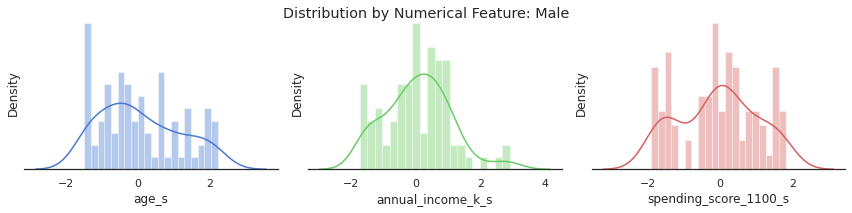

In [22]:
# Numerical features distribution
sns.set(style='white', palette='muted', color_codes=True)
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.despine(left=True)
axs[0] = sns.distplot(df_male['age_s'], bins=20, ax=axs[0], color='b')
axs[1] = sns.distplot(df_male['annual_income_k_s'], bins=20, ax=axs[1], color='g')
axs[2] = sns.distplot(df_male['spending_score_1100_s'], bins=20, ax=axs[2], color='r')

fig.suptitle('Distribution by Numerical Feature: Male')
plt.setp(axs, yticks=[])
plt.tight_layout()
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

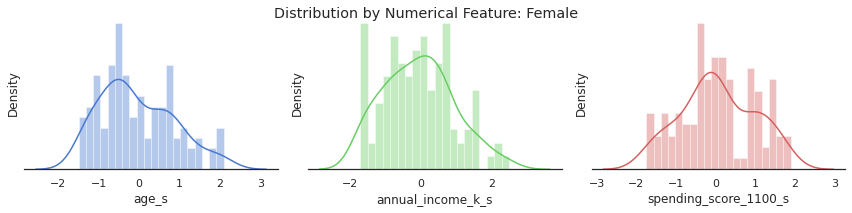

In [23]:
# Numerical features distribution
sns.set(style='white', palette='muted', color_codes=True)
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.despine(left=True)
axs[0] = sns.distplot(df_female['age_s'], bins=20, ax=axs[0], color='b')
axs[1] = sns.distplot(df_female['annual_income_k_s'], bins=20, ax=axs[1], color='g')
axs[2] = sns.distplot(df_female['spending_score_1100_s'], bins=20, ax=axs[2], color='r')

fig.suptitle('Distribution by Numerical Feature: Female')
plt.setp(axs, yticks=[])
plt.tight_layout()
plt.show()

## Elbow Criterion

A commonly used method to
determine the number of clusters is the elbow criterion .
The elbow criterion states that you should choose a number of clusters so that
adding another cluster does not add sufficient information. The elbow is identified by
plotting the ratio of the within cluster variance to between cluster variance against the
number of clusters. The within cluster variance is an estimate of the average of the
variance in the variables used as a basis for segmentation (importance score ratings for
premium savings and neighborhood agent in the Geico example) among customers
who belong to a particular cluster. The between cluster variance is an estimate of the
variance of the segmentation basis variables between customers who belong to different
segments. The objective of cluster analysis (as mentioned before) is to minimize
the within cluster variance and maximize the between cluster variance . Therefore,
as the number of clusters is increasing, the ratio of the within cluster variance to the
between cluster variance will keep decreasing.

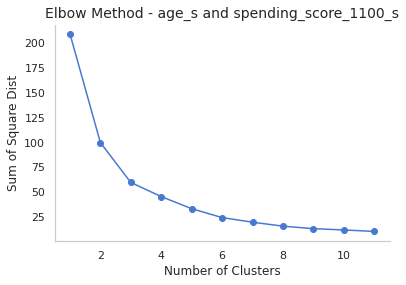

In [24]:
df_1 = df_male.loc[:, ['age_s', 'spending_score_1100_s']]

# Searching for optimun K
plot_elbow_method(df_1)

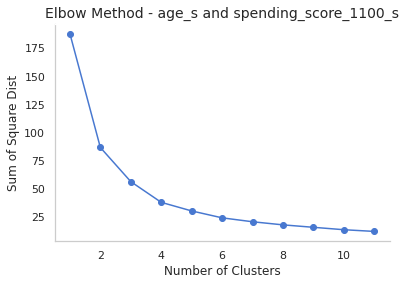

In [25]:
df_1 = df_female.loc[:, ['age_s', 'spending_score_1100_s']]

# Searching for optimun K
plot_elbow_method(df_1)

### Kmeans clustering

K-means clustering belongs to the nonhierarchical class of clustering algorithms. It is one of the more popular algorithms used for clustering in practice because of its simplicity and speed. It is considered to be more robust to different types of variables, is more appropriate for large data sets that are common in marketing, and is less sensitive to some customers who are outliers (in other words, extremely different from others).

For K-means clustering, the user has to specify the number of clusters required before the clustering algorithm is started.  In this example, we'll get guidance from the elbow criterion.

The basic algorithm for K-means clustering is as follows:
1. Choose the number of clusters, k .
2. Generate k random points as cluster centroids.
3. Assign each point to the nearest cluster centroid.
4. Recompute the new cluster centroid.
5. Repeat the two previous steps until some convergence criterion is met. Usually the convergence criterion is that the assignment of customers to clusters has not changed over multiple iterations.

### Males

In [26]:
X = df_male[['age_s', 'annual_income_k_s', 'spending_score_1100_s']]
km = KMeans(5)   # choosing 5 based on elbow chart above
km.fit(X)
centers_male = km.cluster_centers_
centers_male

array([[-0.97358385, -0.73520674,  0.41499633],
       [ 1.42458226, -0.26689794, -0.06389524],
       [ 0.04653158,  0.93623686, -1.39988652],
       [ 1.19192435, -1.39198127, -1.51154184],
       [-0.39889894,  1.01090398,  1.25725171]])

In [27]:
km.labels_

array([0, 0, 3, 3, 3, 0, 0, 3, 0, 0, 0, 0, 0, 3, 3, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2,
       4, 2, 2, 2, 2, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 4, 2, 4, 2, 4],
      dtype=int32)

In [28]:
df_male['label'] = km.labels_

In [29]:
df_male.head(5)

,age_s,annual_income_k_s,spending_score_1100_s,label
0,-1.421003,-1.734646,-0.433713,0
1,-1.277829,-1.734646,1.192711,0
8,1.800414,-1.582351,-1.827791,3
10,2.015175,-1.582351,-1.401823,3
14,-0.132436,-1.544277,-1.440547,3


### Add the unstandardized columns 
From original into the standardized df, and group by label and look at the mean of each column, attribute of each cluster. And try without splitting male and female.

In [30]:
# Add the unstandardized columns
df_male[["age"]] = df[["age"]] 
df_male[["annual_income_k"]] = df[["annual_income_k"]] 
df_male[["spending_score_1100"]] = df[["spending_score_1100"]] 

In [31]:
df_male.sort_values(by=['label'])

,age_s,annual_income_k_s,spending_score_1100_s,label,age,annual_income_k,spending_score_1100
0,-1.421003,-1.734646,-0.433713,0,19,15,39
75,-0.919894,-0.249765,0.147153,0,26,54,54
68,-1.421003,-0.478208,0.340775,0,19,48,59
65,-1.492590,-0.478208,0.340775,0,18,48,59
91,-1.492590,-0.059395,-0.356264,0,18,59,41
...,...,...,...,...,...,...,...
129,-0.060849,0.397491,0.960365,4,38,71,75
127,0.082325,0.397491,1.734852,4,40,71,95
123,0.010738,0.321344,1.579955,4,39,69,91
171,-0.776719,1.006674,0.960365,4,28,87,75


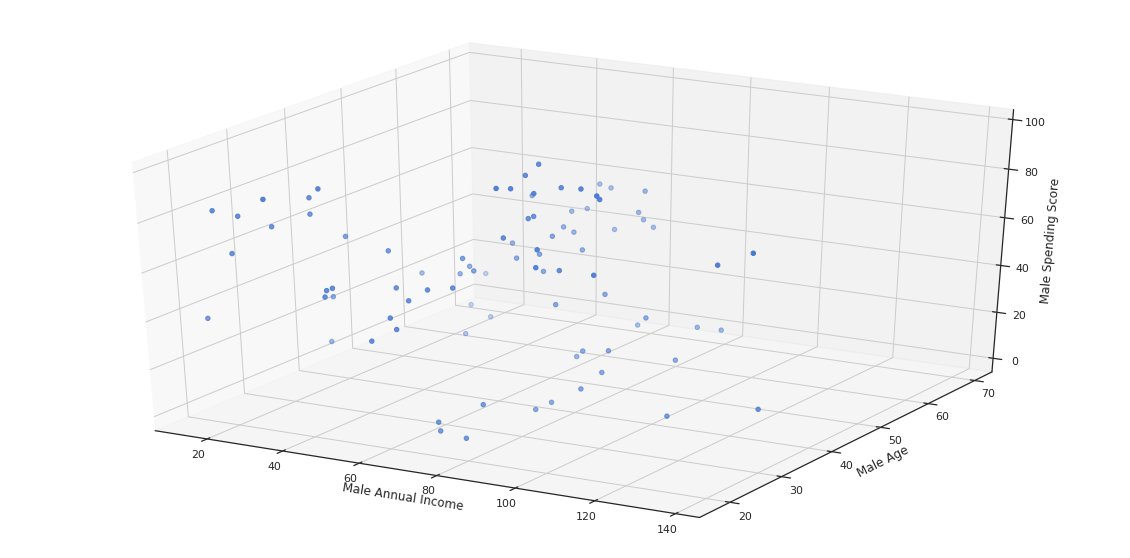

In [32]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(df_male.annual_income_k, df_male.age, df_male.spending_score_1100)

ax.set_xlabel('Male Annual Income')
ax.set_ylabel('Male Age')
ax.set_zlabel('Male Spending Score')

plt.draw()
plt.show()

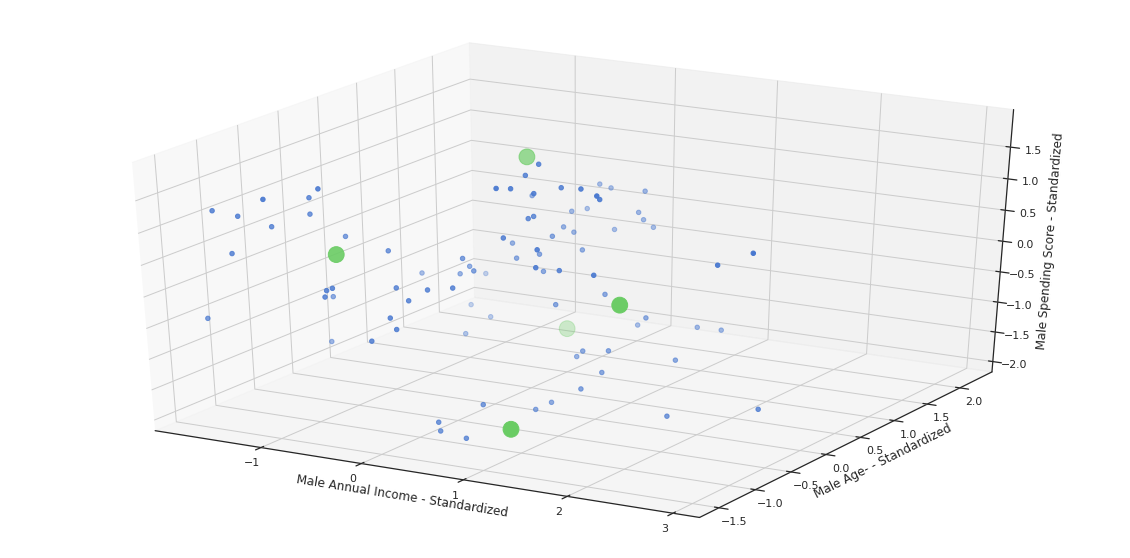

In [33]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(df_male.annual_income_k_s, df_male.age_s, df_male.spending_score_1100_s)
ax.scatter(centers_male[:,0], centers_male[:,1], centers_male[:,2], marker='o', c='g', s=250)
ax.set_xlabel('Male Annual Income - Standardized')
ax.set_ylabel('Male Age- - Standardized')
ax.set_zlabel('Male Spending Score - Standardized')

plt.draw()
plt.show()

### Females

In [34]:
X = df_female[['age_s', 'annual_income_k_s', 'spending_score_1100_s']]
km = KMeans(5)   # choosing 5 based on elbow chart above
km.fit(X)
centers_female = km.cluster_centers_
centers_female

array([[ 0.98258647, -0.49782183, -0.30815223],
       [-0.4513238 ,  0.94090956,  1.17686927],
       [ 0.41162553,  1.20973427, -1.10751742],
       [-0.95844044, -1.32754854,  1.17483827],
       [-0.7668454 , -0.37055081, -0.2975101 ]])

In [35]:
km.labels_

array([4, 3, 4, 3, 4, 3, 3, 3, 0, 3, 4, 3, 0, 0, 0, 0, 3, 3, 0, 3, 0, 3,
       4, 3, 0, 4, 0, 3, 0, 4, 4, 4, 0, 4, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0,
       0, 0, 4, 0, 0, 4, 0, 4, 4, 0, 0, 4, 4, 0, 4, 4, 0, 4, 0, 4, 4, 4,
       4, 0, 0, 0, 0, 4, 1, 4, 1, 4, 1, 1, 2, 1, 2, 4, 1, 1, 2, 2, 1, 2,
       1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2,
       1, 2], dtype=int32)

In [36]:
df_female['label'] = km.labels_

In [37]:
df_female.sort_values(by=['label']).head(5)

,age_s,annual_income_k_s,spending_score_1100_s,label
101,0.726609,0.054826,-0.085194,0
118,0.869783,0.245196,-0.278816,0
117,0.726609,0.169048,0.340775,0
116,1.728827,0.169048,-0.278816,0
40,1.872001,-0.858947,-0.588611,0


### Add the unstandardized columns 
From original into the standardized df, and group by label and look at the mean of each column, attribute of each cluster. And try without splitting male and female.

In [38]:
# Add the unstandardized columns
df_female[["age"]] = df[["age"]] 
df_female[["annual_income_k"]] = df[["annual_income_k"]] 
df_female[["spending_score_1100"]] = df[["spending_score_1100"]] 

In [39]:
df_female.sort_values(by=['label'])

,age_s,annual_income_k_s,spending_score_1100_s,label,age,annual_income_k,spending_score_1100
101,0.726609,0.054826,-0.085194,0,49,62,48
118,0.869783,0.245196,-0.278816,0,51,67,43
117,0.726609,0.169048,0.340775,0,49,65,59
116,1.728827,0.169048,-0.278816,0,63,65,43
40,1.872001,-0.858947,-0.588611,0,65,38,35
...,...,...,...,...,...,...,...
115,-1.421003,0.169048,-0.007745,4,19,65,50
121,-0.060849,0.245196,-0.394989,4,38,67,40
124,-1.134655,0.359417,-0.820957,4,23,70,29
142,-0.776719,0.587861,-0.394989,4,28,76,40


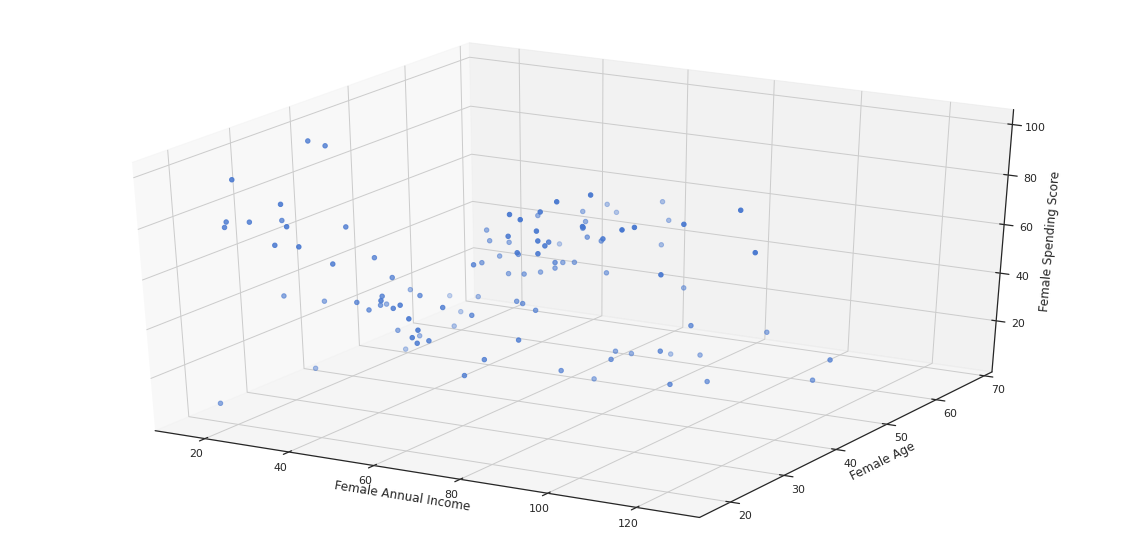

In [40]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(df_female.annual_income_k, df_female.age, df_female.spending_score_1100)

ax.set_xlabel('Female Annual Income')
ax.set_ylabel('Female Age')
ax.set_zlabel('Female Spending Score')

plt.draw()
plt.show()

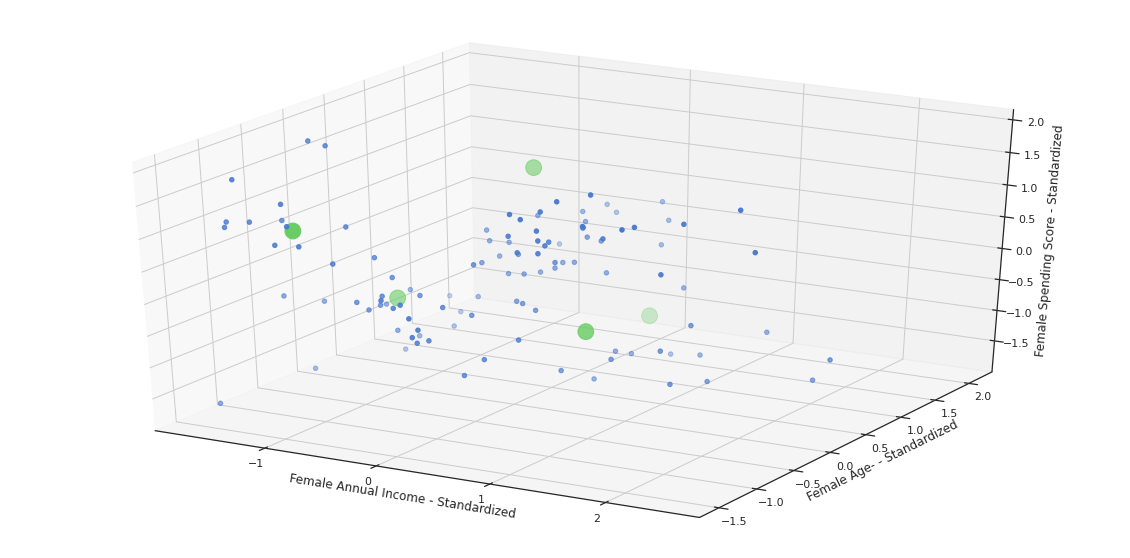

In [41]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(df_female.annual_income_k_s, df_female.age_s, df_female.spending_score_1100_s)
ax.scatter(centers_female[:,0], centers_female[:,1], centers_female[:,2], marker='o', c='g', s=250)
ax.set_xlabel('Female Annual Income - Standardized')
ax.set_ylabel('Female Age- - Standardized')
ax.set_zlabel('Female Spending Score - Standardized')

plt.draw()
plt.show()

### Conclusion

- Among females, older parents and younger but high income earners (who are single presumably) tend to be higher spenders.

- Among males, middle aged males with higher earning power tend to be higher spenders.


### Analysis

- How many clusters can the algorithm see? Why?
- Do any of the features need to be normalized first?
- Consider calculating the means for each of the normalized features?
- Change the number of clusters using the n_clusters parameter, and using feedback from the plot_elbow_method. What happens?
- Change the initialization parameters of KMeans to 'random'. What happens?
- Run the clustering multiple times, do the centroid positions change?

### Read More

https://www.analyticsvidhya.com/blog/2016/11/an-introduction-to-clustering-and-different-methods-of-clustering/

https://www.youtube.com/watch?v=4b5d3muPQmA

*Copyright &copy; 2020 Gino Baltazar All rights reserved.*